# dftio
dftio is to assist machine learning communities in transcribing and manipulating DFT output into a format that is easy to read or used by machine learning models. 

dftio uses multiprocessing to paralleling the processing, and provide a standard dataset class that reads the processed dataset directly.

## Installation
The user can install dftio once located in the root directory, and run:
```bash
pip install .
```

## Data Parsing
The most straight forward using of *dftio* is to parse the DFT output into predefined dataset format. For example, we can run the following script:

```bash
dftio parse -m abacus -r ./test/data/ -p abacus -o test_parse -ham
```

The default parsed style looks like:
```bash
test_parse
`-- MoS2.0
    |-- atomic_numbers.dat
    |-- basis.dat
    |-- cell.dat
    |-- hamiltonians.h5
    |-- pbc.dat
    `-- positions.dat
```

We also support LMDB data format and parrallel parsing, user can run:
```bash
dftio parse -h
```
to check out the details parameters.

## Data Manipulation
DFTIO also provide several apis to assists flexble manipulation of the DFT outputs. Here we provide several demos to display the functions:

### Field
Field object support storing and manipulating a periodic field function.

In [1]:
from dftio.datastruct import Field
import torch

# init from script
f = Field(
    data=torch.randn(10,10,10),
    cell=torch.diag(torch.tensor([5.,5.,5.])),
    na=10, 
    nb=10, 
    nc=10
)

We can also get a field object from a cube file directly

In [2]:
f = Field.from_cube("xxx.cube")

the field instance can be use directly as a function that takes one or a list of 3D coordinates

In [2]:
f([2.,2.,2.]), f(torch.randn(10,3))

(tensor([0.3119]),
 tensor([ 0.6851, -0.0730, -0.3498, -0.0397, -0.0485,  0.3005,  0.1859, -0.3370,
         -0.3645,  0.1454]))

and it have peridoic boundary conditions defined by the cell

In [3]:
# and it have peridoic boundary conditions defined by the cell
f([2.,2.,2.]), f([2.+f._cell[0,0],2.,2.])

(tensor([0.3119]), tensor([0.3119]))

We can rotate, shift the field via field functions:

In [8]:
print("point before shift", f([0.,0.,0.]))
f.set_origin([1.,1.,1.])
print("point after shift", f([0.,0.,0.]))
print("original point", f([-1.,-1.,-1.]))

point before shift tensor([-0.6313])
point after shift tensor([0.3119])
original point tensor([-0.2991])


In [9]:

print("point on x axis before rotation: ", f([2.,0.,0.]))
f.rotate(axis="x", theta=3.14/2)
print("point on x axis after rotation: ", f([2.,0.,0.]))

point on x axis before rotation:  tensor([-0.0051])
point on x axis after rotation:  tensor([-0.0051])


In [25]:
import numpy as np
print("point on y axis before rotation: ", f([0.,2.,0.]))
f.rotate(axis="x", theta=np.pi)
print("point on y axis after 1st 180 rotation: ", f([0.,2.,0.]))
f.rotate(axis="x", theta=np.pi)
print("point on y axis after 2ed 180 rotation: ", f([0.,2.,0.]))

point on y axis before rotation:  tensor([-0.1942])
point on y axis after 1st 180 rotation:  tensor([0.8400])
point on y axis after 2ed 180 rotation:  tensor([-0.1942])


The grid of the field can be attained by

In [10]:
grids = f.grids
print(grids.shape)

torch.Size([120, 120, 120, 3])


### Atomic Orbitals
The Atomic Orbitals class reads the orbital files from DFT calculation, and returns a atomic orbital functions.

In [1]:
from dftio.datastruct import AtomicBasis

ab = AtomicBasis.from_orbfile("./data/Si_gga_6au_100Ry_1s1p.orb")

In [3]:
ab(torch.randn(2,3)).shape # [n_coordinates, n_orbitals] n_orbitals = 1 * 1 + 1 * 3 = 4

torch.Size([2, 4])

### Grid Neighbour List
dftio provides a neighbour list search based on kd-tree, storing the neighbouring atoms of grid points.

In [29]:
from dftio.datastruct import PrimitiveFieldsNeighborList

nblist = PrimitiveFieldsNeighborList(
    cutoffs=[2.0 for _ in f._atomic_numbers],
)

nblist.update(
    pbc=[True, True, True], 
    cell=f._cell, 
    coordinates=f.positions, 
    grids=f.grids.reshape(-1,3)[:100], # just calculate 100 grid point for testing
)

True

In [30]:
neighbours, R_vec = nblist.get_neighbors(10)
print(neighbours, R_vec)

[3 7 2 6 5] [[-2 -1 -1]
 [-1 -1 -1]
 [-2 -1  0]
 [-1 -1  0]
 [-1  0 -1]]


Several hybrid functions can be built based on the basic classes, for example:

### Composing Atomic Basis
$$f(\vec{r})=\sum_iw_i\phi_i(\vec{r})$$

This can be used to calculate for example `wave function`, `local density of states`, or recovering `charge density` after density fitting.


In [133]:

from dftio.op import SingleGridIntegrator
from dftio.datastruct import AtomicBasis
from ase.io import read
import torch
from dftio.op import make_simple_grid

atoms = read("./data/silicon.vasp")

box = torch.as_tensor(atoms.cell.array, dtype=torch.float32).max(dim=1).values.diag()
box[:2,:2] *= 5

n, grids = make_simple_grid(box, 100, 100, 5)
print("shape of the grid: {0}, total number of points: {1}".format(n, len(grids)))

atomic_basis = {
    "Si": AtomicBasis.from_orbfile("./data/Si_gga_6au_100Ry_1s1p.orb")
}

integrator = SingleGridIntegrator(
    atomic_numbers=atoms.get_atomic_numbers(), 
    pbc=atoms.pbc, 
    cell=atoms.cell.array, 
    coordinates=atoms.positions, 
    grids=grids, 
    atomic_basis=atomic_basis
)

# this might take a while since the neighbour list need to be built when initializing the integrator

shape of the grid: (100, 100, 5), total number of points: 50000


In [134]:
weights = torch.zeros((len(atoms), atomic_basis["Si"].irreps.dim))
weights[:,0] = 1.0 # just summing over the s-orbital, so each atom will looks like a ball

results = integrator.integrate(
    weights=weights.flatten(),
).reshape(n)

[]

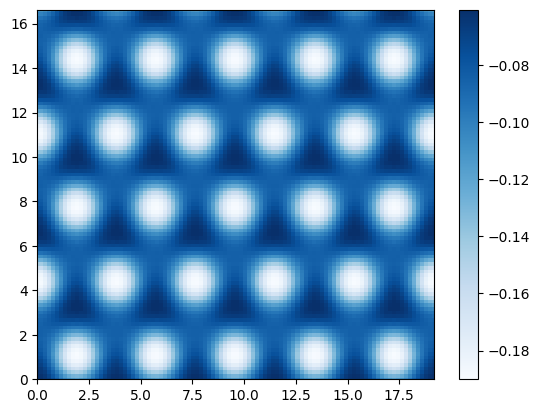

In [141]:
import matplotlib.pyplot as plt
import matplotlib as mpl

iz = 3
norm = mpl.colors.Normalize(vmin=results.min(), vmax=results.max())
ax = plt.axes(xlim=(0.,box[0,0]), ylim=(0,box[1,1]))
X = torch.linspace(0.0, box[0].norm(), n[0])
Y = torch.linspace(0.0, box[1].norm(), n[1])
pc = ax.pcolor(X,Y,results[:,:,iz].T, cmap="Blues", norm=norm)
plt.colorbar(pc, ax=ax)
plt.plot()